# OpenDrift

### Documentation

[https://github.com/opendrift/opendrift/wiki](https://github.com/opendrift/opendrift/wiki)

***

### Installation

`git clone https://github.com/OpenDrift/opendrift.git`

`python setup.py develop --user`

***

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from dateutil.parser import parse
from itertools import repeat
from salishsea_tools import viz_tools
from rotate_fields_python import rotate_fields

from opendrift.readers import reader_netCDF_CF_unstructured
from opendrift.models.oceandrift import OceanDrift

%matplotlib inline
plt.rcParams['font.size'] = 12

***

### OceanDrift model

Required forcing

In [4]:
# OceanDrift require variables
OceanDrift.required_variables

['x_sea_water_velocity',
 'y_sea_water_velocity',
 'x_wind',
 'y_wind',
 'land_binary_mask']

***
### Prepare forcing files
Forcing must be gridded on lon/lat coordinates. The easiest way is to reshape everything onto a single spatial dimension and use `opendrift.readers.reader_netCDF_CF_unstructured`.

In [22]:
# Define paths
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'HRDPS': '/results/forcing/atmospheric/GEM2.5/operational',
    'out': '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing',
    'date_cutoff': '2016 Nov 21',
}
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')

Prefix constructor for SalishSeaCast

In [5]:
def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    fn = '_'.join([f'SalishSea_1{res}', *repeat(date.strftime('%Y%m%d'), 2)])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

Load and process files

In [6]:
# Date
date = datetime(2019, 1, 1)

SalishSeaCast

In [8]:
# Open NEMO velocity results as a list of raw=[u,v]
prefix = make_prefix(date, paths)
NEMO_out = os.path.join(paths['out'], os.path.split(prefix)[-1] + '_opendrift.nc')
raw = []
for k, key in zip(['U', 'V'], ['vozocrtx', 'vomecrty']):
    with xr.open_dataset(prefix + f'_grid_{k}.nc') as data:
        raw.append(data[key][:, 0, ...].values)
        if k is 'U': time = data.time_counter

# Unstagger and rotate NEMO velocities
u, v = viz_tools.rotate_vel(*viz_tools.unstagger(*raw))

# Save NEMO velocities
ds = xr.Dataset(
    {
        'longitude': ('flat', mask.nav_lon[1:, 1:].values.reshape(-1)),
        'latitude': ('flat', mask.nav_lat[1:, 1:].values.reshape(-1)),
        'meshmask': ('flat', mask.tmask[0, 0, 1:, 1:].values.reshape(-1), {'standard_name': 'land_binary_mask'}),
        'u': (['time_counter', 'flat'], u.reshape(time.size, -1), {'standard_name': 'x_sea_water_velocity'}),
        'v': (['time_counter', 'flat'], v.reshape(time.size, -1), {'standard_name': 'y_sea_water_velocity'}),
    },
    coords={'time_counter': time}
)
ds.to_netcdf(NEMO_out)
print(ds)

<xarray.Dataset>
Dimensions:        (flat: 356109, time_counter: 24)
Coordinates:
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2019-01-01T00:30:00 ... 2019-01-01T23:30:00
Dimensions without coordinates: flat
Data variables:
    longitude      (flat) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    latitude       (flat) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    meshmask       (flat) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    u              (time_counter, flat) float32 nan nan nan nan ... nan nan nan
    v              (time_counter, flat) float32 nan nan nan nan ... nan nan nan


HRDPS

In [9]:
# Open HRDPS results and save flattened to netCDF
datestr = date.strftime('ops_y%Ym%md%d.nc')
HRDPS_out = os.path.join(paths['out'], datestr)
with xr.open_dataset(os.path.join(paths['HRDPS'], datestr)) as data:
    time = data.time_counter
    time.attrs['standard_name'] = 'time'
    ds = xr.Dataset(
        {
            'longitude': ('flat', data.nav_lon.values.reshape(-1)),
            'latitude': ('flat', data.nav_lat.values.reshape(-1)),
            'u_wind': (['time_counter', 'flat'], data.u_wind.values.reshape(time.size, -1), {'standard_name': 'x_wind'}),
            'v_wind': (['time_counter', 'flat'], data.v_wind.values.reshape(time.size, -1), {'standard_name': 'y_wind'}),
        },
        coords={'time_counter': time},
    )
ds.to_netcdf(HRDPS_out)
print(ds)

<xarray.Dataset>
Dimensions:       (flat: 68096, time_counter: 24)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2019-01-01 ... 2019-01-01T23:00:00
Dimensions without coordinates: flat
Data variables:
    longitude     (flat) float64 233.0 233.0 233.1 233.1 ... 239.4 239.4 239.5
    latitude      (flat) float64 45.66 45.67 45.67 45.68 ... 52.17 52.18 52.18
    u_wind        (time_counter, flat) float32 -4.6087008 ... 1.1814086
    v_wind        (time_counter, flat) float32 -1.0194238 ... -0.07064758


***

### Read forcing files

In [10]:
# Read forcing
reader_NEMO = reader_netCDF_CF_unstructured.Reader(NEMO_out)
print(reader_NEMO)

Reader: /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
Projection: 
  +proj=latlong
Coverage: [degrees]
  xmin: -126.211052   xmax: 0.000000
  ymin: 0.000000   ymax: 50.992344
  Corners (lon, lat):
    (-126.21,  50.99)  (  0.00,  50.99)
    (-126.21,   0.00)  (  0.00,   0.00)
Vertical levels [m]: 
  Not specified
Available time range:
  start: 2019-01-01 00:30:00   end: 2019-01-01 23:30:00   step: 1:00:00
    24 times (0 missing)
Variables:
  land_binary_mask
  x_sea_water_velocity
  y_sea_water_velocity
  time



In [11]:
# Read forcing
reader_HRDPS = reader_netCDF_CF_unstructured.Reader(HRDPS_out)
print(reader_HRDPS)

Reader: /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
Projection: 
  +proj=latlong
Coverage: [degrees]
  xmin: 230.833052   xmax: 240.529613
  ymin: 45.664901   ymax: 52.179264
  Corners (lon, lat):
    (230.83,  52.18)  (240.53,  52.18)
    (230.83,  45.66)  (240.53,  45.66)
Vertical levels [m]: 
  Not specified
Available time range:
  start: 2019-01-01 00:00:00   end: 2019-01-01 23:00:00   step: 1:00:00
    24 times (0 missing)
Variables:
  x_wind
  y_wind
  time



In [12]:
o = OceanDrift()

12:17:22 INFO: OpenDriftSimulation initialised (version 1.0.6)


In [13]:
o.add_reader([reader_NEMO, reader_HRDPS])

12:17:25 DEBUG: Calculation SRS set to: +units=m +proj=latlong +ellps=WGS84
12:17:25 DEBUG: Using srs for common grid: +proj=latlong
12:17:25 DEBUG: Added reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
12:17:25 DEBUG: Added reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc


In [14]:
o.seed_elements(-123.5, 49.2, radius=500, number=100, time=reader_NEMO.start_time, wind_drift_factor=0.03)

In [16]:
o.run(time_step=timedelta(minutes=15), time_step_output=timedelta(minutes=60))

12:19:30 DEBUG: 
------------------------------------------------------
Software and hardware:
  OpenDrift version 1.0.6
  251.8831558227539 GB memory
  32 processors (x86_64)
  Basemap version 1.1.0
  NumPy version 1.16.2
  SciPy version 1.2.1
  Matplotlib version 3.0.3
  NetCDF4 version 1.4.2
  Python version 3.7.3 (default, Mar 27 2019, 22:11:17) [GCC 7.3.0]
------------------------------------------------------

12:19:30 INFO: Config validation OK
12:19:30 DEBUG: No output file is specified, neglecting export_buffer_length
12:19:30 INFO: Duration, steps or end time not specified, running until end of first reader: 2019-01-01 23:30:00
12:19:30 INFO: Duration, steps or end time not specified, running until end of first reader: 2019-01-01 23:00:00
12:19:30 INFO: Adding a dynamical landmask (resolution "h") based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
12:19:30 DEBUG: Creating Basemap...
12:19:38 DEBUG: Creating rasterized Basemap...
12:19:38 DE

12:19:39 DEBUG: Reader SRS is the same as calculation SRS - rotation of vectors is not needed.
12:19:39 DEBUG: Obtained data for all elements.
12:19:39 DEBUG: ----------------------------------------
12:19:39 DEBUG: Variable group ['x_wind', 'y_wind']
12:19:39 DEBUG: ----------------------------------------
12:19:39 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
12:19:39 DEBUG: ----------------------------------------
12:19:39 DEBUG: Data needed for 100 elements
12:19:39 INFO: ========================
12:19:39 INFO: Exception:
12:19:39 INFO: All 100 particles (-123.51--123.48E, 49.19-49.21N) are outside domain of /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc (230.83-240.53E, 45.66-52.18N)
12:19:39 DEBUG: Traceback (most recent call last):
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/models/basemodel.py", line 932, in get_environment
    z[missing_indices], self.use_block, self.pr

12:19:39 DEBUG: Initialising interpolator.
12:19:39 DEBUG: Interpolating after (2019-01-01 01:30:00) in space  (linearNDFast)
12:19:39 DEBUG: Initialising interpolator.
12:19:39 DEBUG: Interpolating before (2019-01-01 00:30:00, weight 0.25) and
		      after (2019-01-01 01:30:00, weight 0.75) in time
12:19:39 DEBUG: Reader SRS is the same as calculation SRS - rotation of vectors is not needed.
12:19:39 DEBUG: Obtained data for all elements.
12:19:39 DEBUG: ----------------------------------------
12:19:39 DEBUG: Variable group ['x_wind', 'y_wind']
12:19:39 DEBUG: ----------------------------------------
12:19:39 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
12:19:39 DEBUG: ----------------------------------------
12:19:39 DEBUG: Data needed for 100 elements
12:19:39 INFO: ========================
12:19:39 INFO: Exception:
12:19:39 INFO: All 100 particles (-123.51--123.48E, 49.19-49.21N) are outside domain of /ocean/bmoorema

12:19:39 DEBUG: Fetching variables from /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
12:19:40 DEBUG: Making interpolator...
12:19:40 DEBUG: Fetched env-block (size 24x21x100) for time after (2019-01-01 02:30:00)
12:19:40 DEBUG: Interpolating before (2019-01-01 01:30:00) in space  (linearNDFast)
12:19:40 DEBUG: Initialising interpolator.
12:19:40 DEBUG: Interpolating after (2019-01-01 02:30:00) in space  (linearNDFast)
12:19:40 DEBUG: Initialising interpolator.
12:19:40 DEBUG: Interpolating before (2019-01-01 01:30:00, weight 0.75) and
		      after (2019-01-01 02:30:00, weight 0.25) in time
12:19:40 DEBUG: Reader SRS is the same as calculation SRS - rotation of vectors is not needed.
12:19:40 DEBUG: Obtained data for all elements.
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Variable group ['x_wind', 'y_wind']
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Calling re

12:19:40 DEBUG: ======================================================================
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Variable group ['x_sea_water_velocity', 'y_sea_water_velocity']
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Data needed for 100 elements
12:19:40 DEBUG: Reader time:
		2019-01-01 01:30:00 (before)
		2019-01-01 02:30:00 (after)
12:19:40 DEBUG: Interpolating before (2019-01-01 01:30:00) in space  (linearNDFast)
12:19:40 DEBUG: Initialising interpolator.
12:19:40 DEBUG: Interpolating after (2019-01-01 02:30:00) in space  (linearNDFast)
12:19:40 DEBUG: Initialising interpolator.
12:19:40 DEBUG: Interpolating before (2019-01-01 01:30:00, weight 0.25) and
		      after (2019-01-01 02:30:00, weight 0.75) in tim

12:19:40 INFO: 2019-01-01 02:45:00 - step 10 of 90 - 100 active elements (0 deactivated)
12:19:40 DEBUG: 0 elements scheduled.
12:19:40 DEBUG: ======================================================================
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Variable group ['x_sea_water_velocity', 'y_sea_water_velocity']
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Data needed for 100 elements
12:19:40 DEBUG: Reader time:
		2019-01-01 02:30:00 (before)
		2019-01-01 03:30:00 (after)
12:19:40 DEBUG: Fetching variables from /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
12:19:40 DEBUG: Making interpolator...
12:19:40 DEBUG: Fetched env-block (size 24x21x100) for time after 

12:19:40 DEBUG: 		100 active elements
12:19:40 DEBUG: 		49.181728915362456 <- latitude  -> 49.20306559196249
12:19:40 DEBUG: 		-123.48934987676448 <- longitude -> -123.4590029286304
12:19:40 DEBUG: 		z = 0.0
12:19:40 DEBUG: ---------------------------------
12:19:40 DEBUG: No elements to deactivate
12:19:40 DEBUG: Calling OceanDrift.update()
12:19:40 DEBUG: No wind for wind-sheared ocean drift
12:19:40 DEBUG: 100 active elements (0 deactivated)
12:19:40 DEBUG: to be seeded: 0, already seeded 100
12:19:40 DEBUG: ======================================================================
12:19:40 INFO: 2019-01-01 03:15:00 - step 12 of 90 - 100 active elements (0 deactivated)
12:19:40 DEBUG: 0 elements scheduled.
12:19:40 DEBUG: ======================================================================
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Variable group ['x_sea_water_velocity', 'y_sea_water_velocity']
12:19:40 DEBUG: ----------------------------------------
12:1

12:19:40 DEBUG:     land_binary_mask: 0 (min) 0 (max)
12:19:40 DEBUG: ---------------------------------
12:19:40 DEBUG: 		100 active elements
12:19:40 DEBUG: 		49.1801876805354 <- latitude  -> 49.201839686902446
12:19:40 DEBUG: 		-123.48525752709678 <- longitude -> -123.45519155035448
12:19:40 DEBUG: 		z = 0.0
12:19:40 DEBUG: ---------------------------------
12:19:40 DEBUG: No elements to deactivate
12:19:40 DEBUG: Calling OceanDrift.update()
12:19:40 DEBUG: No wind for wind-sheared ocean drift
12:19:40 DEBUG: 100 active elements (0 deactivated)
12:19:40 DEBUG: to be seeded: 0, already seeded 100
12:19:40 DEBUG: ======================================================================
12:19:40 INFO: 2019-01-01 03:45:00 - step 14 of 90 - 100 active elements (0 deactivated)
12:19:40 DEBUG: 0 elements scheduled.
12:19:40 DEBUG: ======================================================================
12:19:40 DEBUG: ----------------------------------------
12:19:40 DEBUG: Variable group ['x_se

12:19:41 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:41 DEBUG: Fetched env-before
12:19:41 DEBUG: No time interpolation needed - right on time.
12:19:41 DEBUG: Obtained data for all elements.
12:19:41 DEBUG: ---------------------------------------
12:19:41 DEBUG: Finished processing all variable groups
12:19:41 DEBUG: ------------ SUMMARY -------------
12:19:41 DEBUG:     x_sea_water_velocity: 0.0934076 (min) 0.152531 (max)
12:19:41 DEBUG:     y_sea_water_velocity: -0.0499632 (min) -0.00479278 (max)
12:19:41 DEBUG:     x_wind: 0 (min) 0 (max)
12:19:41 DEBUG:     y_wind: 0 (min) 0 (max)
12:19:41 DEBUG:     land_binary_mask: 0 (min) 0 (max)
12:19:41 DEBUG: ---------------------------------
12:19:41 DEBUG: 		100 active elements
12:19:41 DEBUG: 		49.17920014922064 <- latitude  -> 49.20092761864967
12:19:41 DEBUG: 		-123.48166505607945 <- longitude -> -123.45194897199491
12:19:41 DEBUG: 		z = 0.0
12:19:41 DEBUG: ---------------------------------
12:19:41 DEBUG: No elements to dea

12:19:41 DEBUG: Reader time:
		None (before)
		None (after)
12:19:41 DEBUG: Fetching variables from basemap_landmask
12:19:41 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:41 DEBUG: Fetched env-before
12:19:41 DEBUG: No time interpolation needed - right on time.
12:19:41 DEBUG: Obtained data for all elements.
12:19:41 DEBUG: ---------------------------------------
12:19:41 DEBUG: Finished processing all variable groups
12:19:41 DEBUG: ------------ SUMMARY -------------
12:19:41 DEBUG:     x_sea_water_velocity: 0.0708548 (min) 0.132999 (max)
12:19:41 DEBUG:     y_sea_water_velocity: -0.00980131 (min) 0.0381309 (max)
12:19:41 DEBUG:     x_wind: 0 (min) 0 (max)
12:19:41 DEBUG:     y_wind: 0 (min) 0 (max)
12:19:41 DEBUG:     land_binary_mask: 0 (min) 0 (max)
12:19:41 DEBUG: ---------------------------------
12:19:41 DEBUG: 		100 active elements
12:19:41 DEBUG: 		49.178919883231515 <- latitude  -> 49.20053941739068
12:19:41 DEBUG: 		-123.47860959207661 <- longitude -> -123.44915169

12:19:41 INFO: ========================
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Variable group ['land_binary_mask']
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Calling reader basemap_landmask
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Data needed for 100 elements
12:19:41 DEBUG: Reader time:
		None (before)
		None (after)
12:19:41 DEBUG: Fetching variables from basemap_landmask
12:19:41 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:41 DEBUG: Fetched env-before
12:19:41 DEBUG: No time interpolation needed - right on time.
12:19:41 DEBUG: Obtained data for all elements.
12:19:41 DEBUG: ---------------------------------------
12:19:41 DEBUG: Finished processing all variable groups
12:19:41 DEBUG: ------------ SUMMARY -------------
12:19:41 DEBUG:     x_sea_water_velocity: 0.0555093 (min) 0.124044 (max)
12:19:41 DEBUG:     y_sea_water_velocity: 0.0281035 (min) 0.078338 (max)
12:19:41 DEBUG:

12:19:41 INFO: ========================
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Variable group ['land_binary_mask']
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Calling reader basemap_landmask
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Data needed for 100 elements
12:19:41 DEBUG: Reader time:
		None (before)
		None (after)
12:19:41 DEBUG: Fetching variables from basemap_landmask
12:19:41 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:41 DEBUG: Fetched env-before
12:19:41 DEBUG: No time interpolation needed - right on time.
12:19:41 DEBUG: Obtained data for all elements.
12:19:41 DEBUG: ---------------------------------------
12:19:41 DEBUG: Finished processing all variable groups
12:19:41 DEBUG: ------------ SUMMARY -------------
12:19:41 DEBUG:     x_sea_water_velocity: 0.0437295 (min) 0.112853 (max)
12:19:41 DEBUG:     y_sea_water_velocity: 0.0636552 (min) 0.115365 (max)
12:19:41 DEBUG:

12:19:41 DEBUG: Traceback (most recent call last):
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/models/basemodel.py", line 932, in get_environment
    z[missing_indices], self.use_block, self.proj)
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/readers/basereader.py", line 379, in get_variables_interpolated
    lat.max(), self.name, self.coverage_string()))
ValueError: All 100 particles (-123.47--123.44E, 49.18-49.20N) are outside domain of /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc (230.83-240.53E, 45.66-52.18N)

12:19:41 INFO: ========================
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Variable group ['land_binary_mask']
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Calling reader basemap_landmask
12:19:41 DEBUG: ----------------------------------------
12:19:41 DEBUG: Data needed for 100 elements
12:19:41 DEBUG: Reader time:
		None (before)
		None (after)
12:19:41 DEB

12:19:42 DEBUG: Traceback (most recent call last):
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/models/basemodel.py", line 932, in get_environment
    z[missing_indices], self.use_block, self.proj)
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/readers/basereader.py", line 379, in get_variables_interpolated
    lat.max(), self.name, self.coverage_string()))
ValueError: All 100 particles (-123.47--123.44E, 49.18-49.20N) are outside domain of /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc (230.83-240.53E, 45.66-52.18N)

12:19:42 INFO: ========================
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Variable group ['land_binary_mask']
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Calling reader basemap_landmask
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Data needed for 100 elements
12:19:42 DEBUG: Reader time:
		None (before)
		None (after)
12:19:42 DEB

12:19:42 DEBUG: Variable group ['x_wind', 'y_wind']
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Data needed for 100 elements
12:19:42 INFO: ========================
12:19:42 INFO: Exception:
12:19:42 INFO: All 100 particles (-123.47--123.44E, 49.19-49.21N) are outside domain of /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc (230.83-240.53E, 45.66-52.18N)
12:19:42 DEBUG: Traceback (most recent call last):
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/models/basemodel.py", line 932, in get_environment
    z[missing_indices], self.use_block, self.proj)
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/readers/basereader.py", line 379, in get_variables_interpolated
    lat.max(), self.name, self.coverage_string()))
ValueError: All 100 particles (

12:19:42 DEBUG: Obtained data for all elements.
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Variable group ['x_wind', 'y_wind']
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Data needed for 100 elements
12:19:42 INFO: ========================
12:19:42 INFO: Exception:
12:19:42 INFO: All 100 particles (-123.47--123.43E, 49.19-49.21N) are outside domain of /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc (230.83-240.53E, 45.66-52.18N)
12:19:42 DEBUG: Traceback (most recent call last):
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/models/basemodel.py", line 932, in get_environment
    z[missing_indices], self.use_block, self.proj)
  File "/data/bmoorema/MEOPAR/opendrift/opendrift/readers/basereader.py", line 379, in get_

12:19:42 DEBUG: Data needed for 100 elements
12:19:42 DEBUG: Reader time:
		2019-01-01 07:30:00 (before)
		2019-01-01 08:30:00 (after)
12:19:42 DEBUG: Interpolating before (2019-01-01 07:30:00) in space  (linearNDFast)
12:19:42 DEBUG: Initialising interpolator.
12:19:42 DEBUG: Interpolating after (2019-01-01 08:30:00) in space  (linearNDFast)
12:19:42 DEBUG: Initialising interpolator.
12:19:42 DEBUG: Interpolating before (2019-01-01 07:30:00, weight 0.50) and
		      after (2019-01-01 08:30:00, weight 0.50) in time
12:19:42 DEBUG: Reader SRS is the same as calculation SRS - rotation of vectors is not needed.
12:19:42 DEBUG: Obtained data for all elements.
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Variable group ['x_wind', 'y_wind']
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/ops_y2019m01d01.nc
12:19:42 DEBUG: ------------------------------------

12:19:42 DEBUG: Variable group ['x_sea_water_velocity', 'y_sea_water_velocity']
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Data needed for 100 elements
12:19:42 DEBUG: Reader time:
		2019-01-01 08:30:00 (before)
		2019-01-01 09:30:00 (after)
12:19:42 DEBUG: Interpolating before (2019-01-01 08:30:00) in space  (linearNDFast)
12:19:42 DEBUG: Initialising interpolator.
12:19:42 DEBUG: No time interpolation needed - right on time.
12:19:42 DEBUG: Reader SRS is the same as calculation SRS - rotation of vectors is not needed.
12:19:42 DEBUG: Obtained data for all elements.
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Variable group ['x_wind', 'y_wind']
12:19:42 DEBUG: ----------------------------------------
12:19:42 DEBUG: Calling reader

12:19:43 DEBUG: to be seeded: 0, already seeded 100
12:19:43 DEBUG: ======================================================================
12:19:43 INFO: 2019-01-01 09:00:00 - step 35 of 90 - 100 active elements (0 deactivated)
12:19:43 DEBUG: 0 elements scheduled.
12:19:43 DEBUG: ======================================================================
12:19:43 DEBUG: ----------------------------------------
12:19:43 DEBUG: Variable group ['x_sea_water_velocity', 'y_sea_water_velocity']
12:19:43 DEBUG: ----------------------------------------
12:19:43 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
12:19:43 DEBUG: ----------------------------------------
12:19:43 DEBUG: Data needed for 100 elements
12:19:43 DEBUG: Reader time:
		2019-01-01 08:30:00 (before)
		2019-01-01 09:30:00 (after)
12:19:43 DEBUG: Interpolating before (2019-01-01 08:30:00) in space  (linearNDFast)
12:19:43 DEBUG: Initialising inter

12:19:43 DEBUG: 		z = 0.0
12:19:43 DEBUG: ---------------------------------
12:19:43 DEBUG: No elements to deactivate
12:19:43 DEBUG: Calling OceanDrift.update()
12:19:43 DEBUG: No wind for wind-sheared ocean drift
12:19:43 DEBUG: 100 active elements (0 deactivated)
12:19:43 DEBUG: to be seeded: 0, already seeded 100
12:19:43 DEBUG: ======================================================================
12:19:43 INFO: 2019-01-01 09:30:00 - step 37 of 90 - 100 active elements (0 deactivated)
12:19:43 DEBUG: 0 elements scheduled.
12:19:43 DEBUG: ======================================================================
12:19:43 DEBUG: ----------------------------------------
12:19:43 DEBUG: Variable group ['x_sea_water_velocity', 'y_sea_water_velocity']
12:19:43 DEBUG: ----------------------------------------
12:19:43 DEBUG: Calling reader /ocean/bmoorema/research/MEOPAR/analysis-ben/data/opendrift_forcing/SalishSea_1h_20190101_20190101_opendrift.nc
12:19:43 DEBUG: ---------------------------

12:19:43 DEBUG:     x_wind: 0 (min) 0 (max)
12:19:43 DEBUG:     y_wind: 0 (min) 0 (max)
12:19:43 DEBUG:     land_binary_mask: 0 (min) 0 (max)
12:19:43 DEBUG: ---------------------------------
12:19:43 DEBUG: 		100 active elements
12:19:43 DEBUG: 		49.195679480069664 <- latitude  -> 49.21517727216413
12:19:43 DEBUG: 		-123.45678493345737 <- longitude -> -123.4166857686411
12:19:43 DEBUG: 		z = 0.0
12:19:43 DEBUG: ---------------------------------
12:19:43 DEBUG: No elements to deactivate
12:19:43 DEBUG: Calling OceanDrift.update()
12:19:43 DEBUG: No wind for wind-sheared ocean drift
12:19:43 DEBUG: 100 active elements (0 deactivated)
12:19:43 DEBUG: to be seeded: 0, already seeded 100
12:19:43 DEBUG: ======================================================================
12:19:43 INFO: 2019-01-01 10:00:00 - step 39 of 90 - 100 active elements (0 deactivated)
12:19:43 DEBUG: 0 elements scheduled.
12:19:43 DEBUG: ======================================================================
12:19:

12:19:43 DEBUG: ---------------------------------------
12:19:43 DEBUG: Finished processing all variable groups
12:19:43 DEBUG: ------------ SUMMARY -------------
12:19:43 DEBUG:     x_sea_water_velocity: 0.12812 (min) 0.169837 (max)
12:19:43 DEBUG:     y_sea_water_velocity: 0.0181074 (min) 0.108894 (max)
12:19:43 DEBUG:     x_wind: 0 (min) 0 (max)
12:19:43 DEBUG:     y_wind: 0 (min) 0 (max)
12:19:43 DEBUG:     land_binary_mask: 0 (min) 0 (max)
12:19:43 DEBUG: ---------------------------------
12:19:43 DEBUG: 		100 active elements
12:19:43 DEBUG: 		49.19674827432264 <- latitude  -> 49.21626582776157
12:19:43 DEBUG: 		-123.45383880508221 <- longitude -> -123.41283420591203
12:19:43 DEBUG: 		z = 0.0
12:19:43 DEBUG: ---------------------------------
12:19:43 DEBUG: No elements to deactivate
12:19:43 DEBUG: Calling OceanDrift.update()
12:19:43 DEBUG: No wind for wind-sheared ocean drift
12:19:43 DEBUG: 100 active elements (0 deactivated)
12:19:43 DEBUG: to be seeded: 0, already seeded 100


12:19:43 DEBUG: Data needed for 100 elements
12:19:43 DEBUG: Reader time:
		None (before)
		None (after)
12:19:43 DEBUG: Fetching variables from basemap_landmask
12:19:43 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:43 DEBUG: Fetched env-before
12:19:43 DEBUG: No time interpolation needed - right on time.
12:19:43 DEBUG: Obtained data for all elements.
12:19:43 DEBUG: ---------------------------------------
12:19:43 DEBUG: Finished processing all variable groups
12:19:43 DEBUG: ------------ SUMMARY -------------
12:19:43 DEBUG:     x_sea_water_velocity: 0.132268 (min) 0.173032 (max)
12:19:43 DEBUG:     y_sea_water_velocity: 0.0109393 (min) 0.0955394 (max)
12:19:43 DEBUG:     x_wind: 0 (min) 0 (max)
12:19:43 DEBUG:     y_wind: 0 (min) 0 (max)
12:19:43 DEBUG:     land_binary_mask: 0 (min) 0 (max)
12:19:43 DEBUG: ---------------------------------
12:19:43 DEBUG: 		100 active elements
12:19:43 DEBUG: 		49.19741415527184 <- latitude  -> 49.217649263563054
12:19:43 DEBUG: 		-123.45

12:19:44 INFO: ========================
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Variable group ['land_binary_mask']
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Calling reader basemap_landmask
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Data needed for 100 elements
12:19:44 DEBUG: Reader time:
		None (before)
		None (after)
12:19:44 DEBUG: Fetching variables from basemap_landmask
12:19:44 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:44 DEBUG: Fetched env-before
12:19:44 DEBUG: No time interpolation needed - right on time.
12:19:44 DEBUG: Obtained data for all elements.
12:19:44 DEBUG: ---------------------------------------
12:19:44 DEBUG: Finished processing all variable groups
12:19:44 DEBUG: ------------ SUMMARY -------------
12:19:44 DEBUG:     x_sea_water_velocity: 0.120224 (min) 0.176886 (max)
12:19:44 DEBUG:     y_sea_water_velocity: 0.0016993 (min) 0.074708 (max)
12:19:44 DEBUG: 

12:19:44 INFO: ========================
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Variable group ['land_binary_mask']
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Calling reader basemap_landmask
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Data needed for 100 elements
12:19:44 DEBUG: Reader time:
		None (before)
		None (after)
12:19:44 DEBUG: Fetching variables from basemap_landmask
12:19:44 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:44 DEBUG: Fetched env-before
12:19:44 DEBUG: No time interpolation needed - right on time.
12:19:44 DEBUG: Obtained data for all elements.
12:19:44 DEBUG: ---------------------------------------
12:19:44 DEBUG: Finished processing all variable groups
12:19:44 DEBUG: ------------ SUMMARY -------------
12:19:44 DEBUG:     x_sea_water_velocity: 0.109909 (min) 0.173968 (max)
12:19:44 DEBUG:     y_sea_water_velocity: -0.00454591 (min) 0.0585054 (max)
12:19:44 DEBU

12:19:44 INFO: ========================
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Variable group ['land_binary_mask']
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Calling reader basemap_landmask
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Data needed for 100 elements
12:19:44 DEBUG: Reader time:
		None (before)
		None (after)
12:19:44 DEBUG: Fetching variables from basemap_landmask
12:19:44 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:44 DEBUG: Fetched env-before
12:19:44 DEBUG: No time interpolation needed - right on time.
12:19:44 DEBUG: Obtained data for all elements.
12:19:44 DEBUG: ---------------------------------------
12:19:44 DEBUG: Finished processing all variable groups
12:19:44 DEBUG: ------------ SUMMARY -------------
12:19:44 DEBUG:     x_sea_water_velocity: 0.102088 (min) 0.162115 (max)
12:19:44 DEBUG:     y_sea_water_velocity: -0.010179 (min) 0.047322 (max)
12:19:44 DEBUG: 

12:19:44 INFO: ========================
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Variable group ['land_binary_mask']
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Calling reader basemap_landmask
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Data needed for 100 elements
12:19:44 DEBUG: Reader time:
		None (before)
		None (after)
12:19:44 DEBUG: Fetching variables from basemap_landmask
12:19:44 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:44 DEBUG: Fetched env-before
12:19:44 DEBUG: No time interpolation needed - right on time.
12:19:44 DEBUG: Obtained data for all elements.
12:19:44 DEBUG: ---------------------------------------
12:19:44 DEBUG: Finished processing all variable groups
12:19:44 DEBUG: ------------ SUMMARY -------------
12:19:44 DEBUG:     x_sea_water_velocity: 0.0915921 (min) 0.147149 (max)
12:19:44 DEBUG:     y_sea_water_velocity: -0.0195439 (min) 0.0467296 (max)
12:19:44 DEBU

12:19:44 INFO: ========================
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Variable group ['land_binary_mask']
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Calling reader basemap_landmask
12:19:44 DEBUG: ----------------------------------------
12:19:44 DEBUG: Data needed for 100 elements
12:19:44 DEBUG: Reader time:
		None (before)
		None (after)
12:19:44 DEBUG: Fetching variables from basemap_landmask
12:19:44 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:44 DEBUG: Fetched env-before
12:19:44 DEBUG: No time interpolation needed - right on time.
12:19:44 DEBUG: Obtained data for all elements.
12:19:44 DEBUG: ---------------------------------------
12:19:44 DEBUG: Finished processing all variable groups
12:19:44 DEBUG: ------------ SUMMARY -------------
12:19:44 DEBUG:     x_sea_water_velocity: 0.0776814 (min) 0.136094 (max)
12:19:44 DEBUG:     y_sea_water_velocity: -0.0266123 (min) 0.0543062 (max)
12:19:44 DEBU

12:19:45 INFO: ========================
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Variable group ['land_binary_mask']
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Calling reader basemap_landmask
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Data needed for 100 elements
12:19:45 DEBUG: Reader time:
		None (before)
		None (after)
12:19:45 DEBUG: Fetching variables from basemap_landmask
12:19:45 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:45 DEBUG: Fetched env-before
12:19:45 DEBUG: No time interpolation needed - right on time.
12:19:45 DEBUG: Obtained data for all elements.
12:19:45 DEBUG: ---------------------------------------
12:19:45 DEBUG: Finished processing all variable groups
12:19:45 DEBUG: ------------ SUMMARY -------------
12:19:45 DEBUG:     x_sea_water_velocity: 0.0635605 (min) 0.130139 (max)
12:19:45 DEBUG:     y_sea_water_velocity: -0.0272948 (min) 0.0596566 (max)
12:19:45 DEBU

12:19:45 INFO: ========================
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Variable group ['land_binary_mask']
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Calling reader basemap_landmask
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Data needed for 100 elements
12:19:45 DEBUG: Reader time:
		None (before)
		None (after)
12:19:45 DEBUG: Fetching variables from basemap_landmask
12:19:45 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:45 DEBUG: Fetched env-before
12:19:45 DEBUG: No time interpolation needed - right on time.
12:19:45 DEBUG: Obtained data for all elements.
12:19:45 DEBUG: ---------------------------------------
12:19:45 DEBUG: Finished processing all variable groups
12:19:45 DEBUG: ------------ SUMMARY -------------
12:19:45 DEBUG:     x_sea_water_velocity: 0.0502492 (min) 0.127749 (max)
12:19:45 DEBUG:     y_sea_water_velocity: -0.023485 (min) 0.0639961 (max)
12:19:45 DEBUG

12:19:45 INFO: ========================
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Variable group ['land_binary_mask']
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Calling reader basemap_landmask
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Data needed for 100 elements
12:19:45 DEBUG: Reader time:
		None (before)
		None (after)
12:19:45 DEBUG: Fetching variables from basemap_landmask
12:19:45 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:45 DEBUG: Fetched env-before
12:19:45 DEBUG: No time interpolation needed - right on time.
12:19:45 DEBUG: Obtained data for all elements.
12:19:45 DEBUG: ---------------------------------------
12:19:45 DEBUG: Finished processing all variable groups
12:19:45 DEBUG: ------------ SUMMARY -------------
12:19:45 DEBUG:     x_sea_water_velocity: 0.0417655 (min) 0.130497 (max)
12:19:45 DEBUG:     y_sea_water_velocity: -0.0168267 (min) 0.0747065 (max)
12:19:45 DEBU

12:19:45 INFO: ========================
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Variable group ['land_binary_mask']
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Calling reader basemap_landmask
12:19:45 DEBUG: ----------------------------------------
12:19:45 DEBUG: Data needed for 100 elements
12:19:45 DEBUG: Reader time:
		None (before)
		None (after)
12:19:45 DEBUG: Fetching variables from basemap_landmask
12:19:45 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:45 DEBUG: Fetched env-before
12:19:45 DEBUG: No time interpolation needed - right on time.
12:19:45 DEBUG: Obtained data for all elements.
12:19:45 DEBUG: ---------------------------------------
12:19:45 DEBUG: Finished processing all variable groups
12:19:45 DEBUG: ------------ SUMMARY -------------
12:19:45 DEBUG:     x_sea_water_velocity: 0.0397495 (min) 0.125595 (max)
12:19:45 DEBUG:     y_sea_water_velocity: -0.00740536 (min) 0.0879612 (max)
12:19:45 DEB

12:19:46 INFO: ========================
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Variable group ['land_binary_mask']
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Calling reader basemap_landmask
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Data needed for 100 elements
12:19:46 DEBUG: Reader time:
		None (before)
		None (after)
12:19:46 DEBUG: Fetching variables from basemap_landmask
12:19:46 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:46 DEBUG: Fetched env-before
12:19:46 DEBUG: No time interpolation needed - right on time.
12:19:46 DEBUG: Obtained data for all elements.
12:19:46 DEBUG: ---------------------------------------
12:19:46 DEBUG: Finished processing all variable groups
12:19:46 DEBUG: ------------ SUMMARY -------------
12:19:46 DEBUG:     x_sea_water_velocity: 0.0378769 (min) 0.114414 (max)
12:19:46 DEBUG:     y_sea_water_velocity: 0.00143874 (min) 0.104784 (max)
12:19:46 DEBUG

12:19:46 INFO: ========================
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Variable group ['land_binary_mask']
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Calling reader basemap_landmask
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Data needed for 100 elements
12:19:46 DEBUG: Reader time:
		None (before)
		None (after)
12:19:46 DEBUG: Fetching variables from basemap_landmask
12:19:46 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:46 DEBUG: Fetched env-before
12:19:46 DEBUG: No time interpolation needed - right on time.
12:19:46 DEBUG: Obtained data for all elements.
12:19:46 DEBUG: ---------------------------------------
12:19:46 DEBUG: Finished processing all variable groups
12:19:46 DEBUG: ------------ SUMMARY -------------
12:19:46 DEBUG:     x_sea_water_velocity: 0.0376377 (min) 0.107232 (max)
12:19:46 DEBUG:     y_sea_water_velocity: 0.0156663 (min) 0.127432 (max)
12:19:46 DEBUG:

12:19:46 INFO: ========================
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Variable group ['land_binary_mask']
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Calling reader basemap_landmask
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Data needed for 100 elements
12:19:46 DEBUG: Reader time:
		None (before)
		None (after)
12:19:46 DEBUG: Fetching variables from basemap_landmask
12:19:46 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:46 DEBUG: Fetched env-before
12:19:46 DEBUG: No time interpolation needed - right on time.
12:19:46 DEBUG: Obtained data for all elements.
12:19:46 DEBUG: ---------------------------------------
12:19:46 DEBUG: Finished processing all variable groups
12:19:46 DEBUG: ------------ SUMMARY -------------
12:19:46 DEBUG:     x_sea_water_velocity: 0.0336456 (min) 0.102909 (max)
12:19:46 DEBUG:     y_sea_water_velocity: 0.0411368 (min) 0.141666 (max)
12:19:46 DEBUG:

12:19:46 INFO: ========================
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Variable group ['land_binary_mask']
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Calling reader basemap_landmask
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Data needed for 100 elements
12:19:46 DEBUG: Reader time:
		None (before)
		None (after)
12:19:46 DEBUG: Fetching variables from basemap_landmask
12:19:46 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:46 DEBUG: Fetched env-before
12:19:46 DEBUG: No time interpolation needed - right on time.
12:19:46 DEBUG: Obtained data for all elements.
12:19:46 DEBUG: ---------------------------------------
12:19:46 DEBUG: Finished processing all variable groups
12:19:46 DEBUG: ------------ SUMMARY -------------
12:19:46 DEBUG:     x_sea_water_velocity: 0.0214768 (min) 0.10779 (max)
12:19:46 DEBUG:     y_sea_water_velocity: 0.0626393 (min) 0.144308 (max)
12:19:46 DEBUG: 

12:19:46 INFO: ========================
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Variable group ['land_binary_mask']
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Calling reader basemap_landmask
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Data needed for 100 elements
12:19:46 DEBUG: Reader time:
		None (before)
		None (after)
12:19:46 DEBUG: Fetching variables from basemap_landmask
12:19:46 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:46 DEBUG: Fetched env-before
12:19:46 DEBUG: No time interpolation needed - right on time.
12:19:46 DEBUG: Obtained data for all elements.
12:19:46 DEBUG: ---------------------------------------
12:19:46 DEBUG: Finished processing all variable groups
12:19:46 DEBUG: ------------ SUMMARY -------------
12:19:46 DEBUG:     x_sea_water_velocity: 0.0271961 (min) 0.118277 (max)
12:19:46 DEBUG:     y_sea_water_velocity: 0.0859408 (min) 0.179308 (max)
12:19:46 DEBUG:

12:19:46 INFO: ========================
12:19:46 DEBUG: ----------------------------------------
12:19:46 DEBUG: Variable group ['land_binary_mask']
12:19:46 DEBUG: ----------------------------------------
12:19:47 DEBUG: Calling reader basemap_landmask
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Data needed for 100 elements
12:19:47 DEBUG: Reader time:
		None (before)
		None (after)
12:19:47 DEBUG: Fetching variables from basemap_landmask
12:19:47 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:47 DEBUG: Fetched env-before
12:19:47 DEBUG: No time interpolation needed - right on time.
12:19:47 DEBUG: Obtained data for all elements.
12:19:47 DEBUG: ---------------------------------------
12:19:47 DEBUG: Finished processing all variable groups
12:19:47 DEBUG: ------------ SUMMARY -------------
12:19:47 DEBUG:     x_sea_water_velocity: 0.0147424 (min) 0.131125 (max)
12:19:47 DEBUG:     y_sea_water_velocity: 0.089315 (min) 0.339413 (max)
12:19:47 DEBUG: 

12:19:47 INFO: ========================
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Variable group ['land_binary_mask']
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Calling reader basemap_landmask
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Data needed for 100 elements
12:19:47 DEBUG: Reader time:
		None (before)
		None (after)
12:19:47 DEBUG: Fetching variables from basemap_landmask
12:19:47 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:47 DEBUG: Fetched env-before
12:19:47 DEBUG: No time interpolation needed - right on time.
12:19:47 DEBUG: Obtained data for all elements.
12:19:47 DEBUG: ---------------------------------------
12:19:47 DEBUG: Finished processing all variable groups
12:19:47 DEBUG: ------------ SUMMARY -------------
12:19:47 DEBUG:     x_sea_water_velocity: 0.044125 (min) 0.142936 (max)
12:19:47 DEBUG:     y_sea_water_velocity: 0.108547 (min) 0.34125 (max)
12:19:47 DEBUG:   

12:19:47 INFO: ========================
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Variable group ['land_binary_mask']
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Calling reader basemap_landmask
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Data needed for 100 elements
12:19:47 DEBUG: Reader time:
		None (before)
		None (after)
12:19:47 DEBUG: Fetching variables from basemap_landmask
12:19:47 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:47 DEBUG: Fetched env-before
12:19:47 DEBUG: No time interpolation needed - right on time.
12:19:47 DEBUG: Obtained data for all elements.
12:19:47 DEBUG: ---------------------------------------
12:19:47 DEBUG: Finished processing all variable groups
12:19:47 DEBUG: ------------ SUMMARY -------------
12:19:47 DEBUG:     x_sea_water_velocity: 0.0269356 (min) 0.15555 (max)
12:19:47 DEBUG:     y_sea_water_velocity: 0.0999043 (min) 0.438632 (max)
12:19:47 DEBUG: 

12:19:47 INFO: ========================
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Variable group ['land_binary_mask']
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Calling reader basemap_landmask
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Data needed for 100 elements
12:19:47 DEBUG: Reader time:
		None (before)
		None (after)
12:19:47 DEBUG: Fetching variables from basemap_landmask
12:19:47 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:47 DEBUG: Fetched env-before
12:19:47 DEBUG: No time interpolation needed - right on time.
12:19:47 DEBUG: Obtained data for all elements.
12:19:47 DEBUG: ---------------------------------------
12:19:47 DEBUG: Finished processing all variable groups
12:19:47 DEBUG: ------------ SUMMARY -------------
12:19:47 DEBUG:     x_sea_water_velocity: 0.0623196 (min) 0.195322 (max)
12:19:47 DEBUG:     y_sea_water_velocity: 0.10715 (min) 0.420944 (max)
12:19:47 DEBUG:  

12:19:47 INFO: ========================
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Variable group ['land_binary_mask']
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Calling reader basemap_landmask
12:19:47 DEBUG: ----------------------------------------
12:19:47 DEBUG: Data needed for 100 elements
12:19:47 DEBUG: Reader time:
		None (before)
		None (after)
12:19:47 DEBUG: Fetching variables from basemap_landmask
12:19:47 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:47 DEBUG: Fetched env-before
12:19:47 DEBUG: No time interpolation needed - right on time.
12:19:47 DEBUG: Obtained data for all elements.
12:19:47 DEBUG: ---------------------------------------
12:19:47 DEBUG: Finished processing all variable groups
12:19:47 DEBUG: ------------ SUMMARY -------------
12:19:47 DEBUG:     x_sea_water_velocity: 0.0581578 (min) 0.27244 (max)
12:19:47 DEBUG:     y_sea_water_velocity: 0.125117 (min) 0.47669 (max)
12:19:47 DEBUG:   

12:19:48 INFO: ========================
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Variable group ['land_binary_mask']
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Calling reader basemap_landmask
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Data needed for 100 elements
12:19:48 DEBUG: Reader time:
		None (before)
		None (after)
12:19:48 DEBUG: Fetching variables from basemap_landmask
12:19:48 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:48 DEBUG: Fetched env-before
12:19:48 DEBUG: No time interpolation needed - right on time.
12:19:48 DEBUG: Obtained data for all elements.
12:19:48 DEBUG: ---------------------------------------
12:19:48 DEBUG: Finished processing all variable groups
12:19:48 DEBUG: ------------ SUMMARY -------------
12:19:48 DEBUG:     x_sea_water_velocity: 0.0889118 (min) 0.315897 (max)
12:19:48 DEBUG:     y_sea_water_velocity: 0.137933 (min) 0.422046 (max)
12:19:48 DEBUG: 

12:19:48 INFO: ========================
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Variable group ['land_binary_mask']
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Calling reader basemap_landmask
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Data needed for 100 elements
12:19:48 DEBUG: Reader time:
		None (before)
		None (after)
12:19:48 DEBUG: Fetching variables from basemap_landmask
12:19:48 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:48 DEBUG: Fetched env-before
12:19:48 DEBUG: No time interpolation needed - right on time.
12:19:48 DEBUG: Obtained data for all elements.
12:19:48 DEBUG: ---------------------------------------
12:19:48 DEBUG: Finished processing all variable groups
12:19:48 DEBUG: ------------ SUMMARY -------------
12:19:48 DEBUG:     x_sea_water_velocity: 0.098764 (min) 0.343017 (max)
12:19:48 DEBUG:     y_sea_water_velocity: 0.150589 (min) 0.395281 (max)
12:19:48 DEBUG:  

12:19:48 INFO: ========================
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Variable group ['land_binary_mask']
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Calling reader basemap_landmask
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Data needed for 100 elements
12:19:48 DEBUG: Reader time:
		None (before)
		None (after)
12:19:48 DEBUG: Fetching variables from basemap_landmask
12:19:48 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:48 DEBUG: Fetched env-before
12:19:48 DEBUG: No time interpolation needed - right on time.
12:19:48 DEBUG: Obtained data for all elements.
12:19:48 DEBUG: ---------------------------------------
12:19:48 DEBUG: Finished processing all variable groups
12:19:48 DEBUG: ------------ SUMMARY -------------
12:19:48 DEBUG:     x_sea_water_velocity: 0.136334 (min) 0.335063 (max)
12:19:48 DEBUG:     y_sea_water_velocity: 0.158084 (min) 0.368754 (max)
12:19:48 DEBUG:  

12:19:48 INFO: ========================
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Variable group ['land_binary_mask']
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Calling reader basemap_landmask
12:19:48 DEBUG: ----------------------------------------
12:19:48 DEBUG: Data needed for 100 elements
12:19:48 DEBUG: Reader time:
		None (before)
		None (after)
12:19:48 DEBUG: Fetching variables from basemap_landmask
12:19:48 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:48 DEBUG: Fetched env-before
12:19:48 DEBUG: No time interpolation needed - right on time.
12:19:48 DEBUG: Obtained data for all elements.
12:19:48 DEBUG: ---------------------------------------
12:19:48 DEBUG: Finished processing all variable groups
12:19:48 DEBUG: ------------ SUMMARY -------------
12:19:48 DEBUG:     x_sea_water_velocity: 0.146544 (min) 0.345878 (max)
12:19:48 DEBUG:     y_sea_water_velocity: 0.179863 (min) 0.300462 (max)
12:19:48 DEBUG:  

12:19:49 INFO: ========================
12:19:49 DEBUG: ----------------------------------------
12:19:49 DEBUG: Variable group ['land_binary_mask']
12:19:49 DEBUG: ----------------------------------------
12:19:49 DEBUG: Calling reader basemap_landmask
12:19:49 DEBUG: ----------------------------------------
12:19:49 DEBUG: Data needed for 100 elements
12:19:49 DEBUG: Reader time:
		None (before)
		None (after)
12:19:49 DEBUG: Fetching variables from basemap_landmask
12:19:49 DEBUG: Checking 0 of 100 coordinates to polygons
12:19:49 DEBUG: Fetched env-before
12:19:49 DEBUG: No time interpolation needed - right on time.
12:19:49 DEBUG: Obtained data for all elements.
12:19:49 DEBUG: ---------------------------------------
12:19:49 DEBUG: Finished processing all variable groups
12:19:49 DEBUG: ------------ SUMMARY -------------
12:19:49 DEBUG:     x_sea_water_velocity: 0.170047 (min) 0.26971 (max)
12:19:49 DEBUG:     y_sea_water_velocity: 0.131377 (min) 0.253518 (max)
12:19:49 DEBUG:   

/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/bmoorema/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


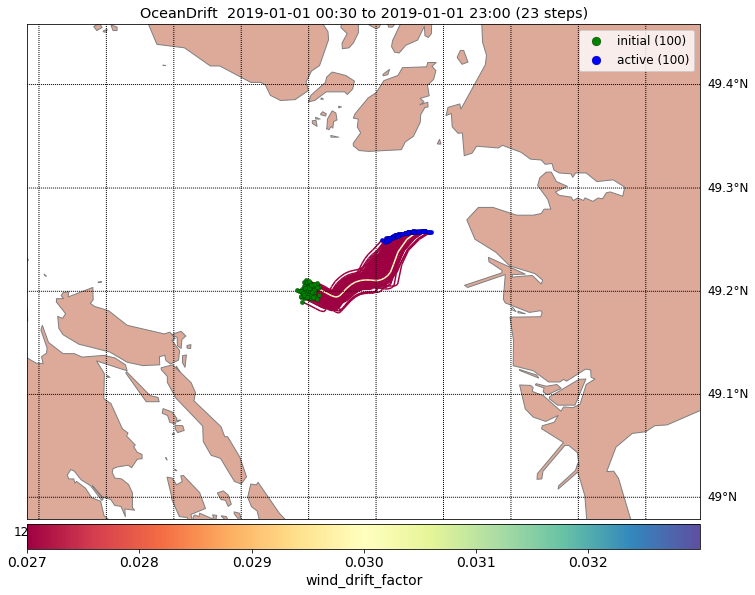

(<mpl_toolkits.basemap.Basemap at 0x7f75ca8005f8>,
 <module 'matplotlib.pyplot' from '/home/bmoorema/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>)

In [15]:
o.plot(linecolor='wind_drift_factor')

***

## Vector Rotation

From Hauke

In [14]:
# Rotation from Hauke
prefix = make_prefix(date, paths)
fn_out = os.path.join(paths['out'], 'rotated_Hauke.nc')
r = rotate_fields()
r.rotate_fields(prefix + '_grid_U.nc', prefix + '_grid_V.nc', os.path.join(paths['out'], 'rotated_Hauke.nc'), 'SSC')

getting grid rotation coefficients
rotating
unstaggering
saving


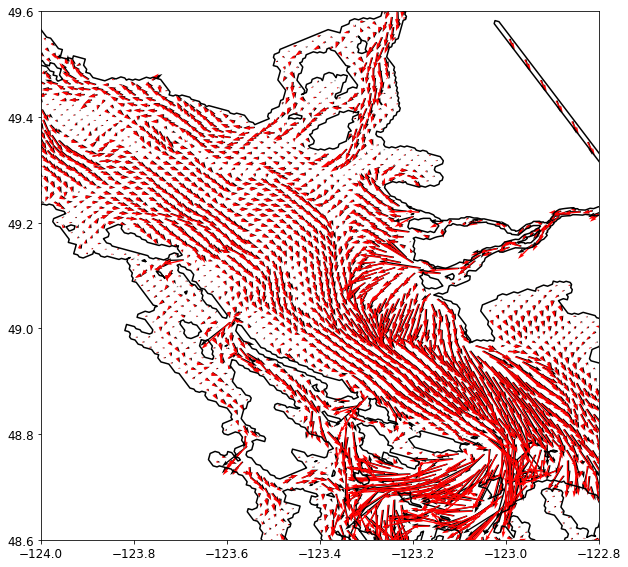

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim([-124, -122.8])
ax.set_ylim([48.6, 49.6])
viz_tools.set_aspect(ax)
ax.contour(mask.nav_lon, mask.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
for fn, u_key, v_key, color in zip([fn_out, NEMO_out], ['x_sea_water_velocity', 'u'], ['y_sea_water_velocity', 'v'], ['k', 'r']):
    with xr.open_dataset(fn).isel(time_counter=0) as data:
        u = np.ma.masked_where(data.meshmask == 0, data[u_key])[::10]
        v = np.ma.masked_where(data.meshmask == 0, data[v_key])[::10]
        q = ax.quiver(data.longitude[::10], data.latitude[::10], u, v, scale=20, color=color)